In [1]:
import os
import torch
import numpy as np
from matplotlib import image
from nn_modules import Encoder,Transformer_Decoder_Layer
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from shapely.wkt import loads
import json
import cv2 as cv

In [136]:
img_dir = r"C:\Users\jairl\Documents\GitHub\CORE\Data\AE_debug\images"
label_dir = r'C:\Users\jairl\Documents\GitHub\CORE\Data\Json'
crop_size = 128
n_samples = 10
batch_size = n_samples

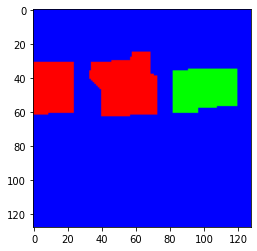

In [90]:
samples_batch = []
masks_batch = []


colours_dict = {'no-damage':[0,1,0],
           'minor-damage':[0,1,0],
           'major-damage':[1,0,0],
           'destroyed':[1,0,0]
           }
for _filename in os.listdir(img_dir):
    _filename = os.path.splitext(_filename)[0]
    if "post" in _filename:
        _label_file = open(f'{label_dir}/{_filename}.json')
        _label_data =json.load(_label_file)
        _img = image.imread(f'{img_dir}/{_filename}.png')
        _polygons = []
        out = np.zeros_like(_img)
        out[:,:,-1]=1
        for _obj in _label_data['features']['xy']:
            _polygon = loads(_obj['wkt'])
            _polygons.append(_polygon)
            _polygon = np.array(list(_polygon.exterior.coords),dtype=np.int32)
            try:
                colour = colours_dict[_obj['properties']['subtype']]
            except KeyError:
                colour = [0,0,0]
            out = cv.fillPoly(out,[_polygon],colour)

        for n in range(n_samples):
            x = np.random.randint(0,_img.shape[0]-crop_size) + np.array([0,crop_size])
            y = np.random.randint(0,_img.shape[1]-crop_size) + np.array([0,crop_size])
            sample = _img[x[0]:x[1],y[0]:y[1]] 
            mask = out[x[0]:x[1],y[0]:y[1]]
            samples_batch.append(sample)
            masks_batch.append(mask)
            plt.imshow(mask)

samples_batch = np.array(samples_batch)
masks_batch = np.array(masks_batch)

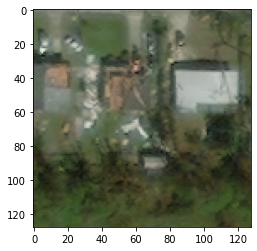

In [91]:
plt.imshow(sample)

In [15]:
depths=[3, 3, 3, 9, 3]
dims=[3, 6, 12, 24, 48]
dConv_kernel_size = 5
encoder = Encoder(depths=depths,dims = dims, dConv_kernel_size = dConv_kernel_size)

In [130]:
#patchify
#fig, axs = plt.subplots(8, 8)
sample_patches = []
classes_patches = []
#label_patches = []
for sample,label in zip(samples_batch,masks_batch):

    patch_size = 16
    n_x = sample.shape[1]//patch_size
    n_y = sample.shape[0]//patch_size
    num_patches = n_x*n_y
    for n in range(n_x):
        for m in range(n_y):
            sample_patch = sample[n*patch_size:(n+1)*patch_size,m*patch_size:(m+1)*patch_size,:]
            label_patch = label[n*patch_size:(n+1)*patch_size,m*patch_size:(m+1)*patch_size,:]
            #axs[n,m].imshow(sample_patch)
            sample_patches.append(sample_patch.swapaxes(0,-1))
            classes_patches.append(label_patch.sum(axis=(0,1))/patch_size**2)
            #label_patches.append(label_patch)
sample_patches = torch.tensor(sample_patches)
classes_patches = torch.tensor(classes_patches)
#label_patches = torch.tensor(label_patches)

In [131]:
sample_patches.shape

torch.Size([640, 3, 16, 16])

In [132]:
num_patches

64

In [139]:
encodings = encoder(sample_patches).squeeze()
encodings = encodings.reshape(batch_size,num_patches,48)
encodings.shape

torch.Size([10, 64, 48])

[0.5390625 0.        0.4609375]


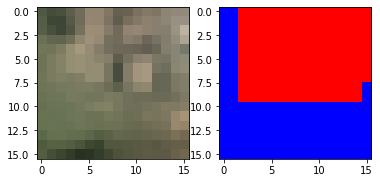

In [47]:
fig, axs = plt.subplots(1, 2)
i = np.random.randint(0,len(classes_patches))
axs[0].imshow(sample_patches[i])
axs[1].imshow(label_patches[i])
print(classes_patches[i])